In [1]:
import pandas as pd
import numpy as np
import math
import glob
import cv2
import pillow_heif as ph
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, RandomFlip, RandomRotation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Project Background
Labubus - do you know them? They are dolls which have exploded in popularity recently, thanks to celebrity and influencer marketing that's gone viral on social media. With their rapid rise in popularity, many people are participating in the secondary market of buying & reselling labubus and making a good profit. Since the supply is far under the demand for these products worldwide, many people are looking to buy from resellers for more than their original sell price.

Unfortunately, this means many bad actors are manufacturing and selling fake labubus on online marketplaces, while advertising them as real genuine products. The end result is consumers paying hard-earned money for products that are worth far less than they think, and being scammed.

This project is aimed at building a CNN deep learning model that can flag fake labubus based on images. This model, once built, could be implemented in a web-based tool that end users can upload images to in order to see if a labubu is fake. Or, it can be embedded into an online marketplace and scan all images when resellers are creating listings and uploading their images. An image with high probability of being fake can be kicked back, or a warning can be given to prospective buyers.

# Notebook Contents
**Data Analysis & Pre-Processing**
* Loading images
* Plotting images
* Image resizing
* Image cropping
* Sample the resized images
* Standardize image pixel data
* Split into train, validation, test
* Shuffle training data

**Building a CNN Model**
* V1 Model: 3-Conv > Max Pool > Dense
* V2 Model: More Max Pooling
* V3 Model: More max pooling & ConvLayers with stride 2
* V4 Model: Adding Image Augmentation
* V5 Model: V3 Model w/ Dropout layer
* V6 Model: V3 Model w/ additional Dense & Dropout layers

**Model Evaluation on Test Data**

**Conclusion**

# Data Analysis & Pre-Processing

### Loading images
I collected 200 images of real and fake Labubus (100 of each) from a mix of social media posts, online reselling platforms, and my own pictures of Labubus owned by my girlfriend. Many more images in the order of thousands would likely be needed for a model to learn the subtle visual marks of a fake labubu, but this is enough for an initial project and proof-of-concept demonstration.

In [2]:
fake_img_paths = glob.glob('*.png', root_dir = 'images_fake')
real_img_paths = glob.glob('*.png', root_dir = 'images_real') + glob.glob('*.heic', root_dir = 'images_real')

In [3]:
def load_images(paths, folder):
    """
    Load images of .PNG or .HEIC formats into a numpy array

    Args:
        paths: list of filenames for the images
        folder: folder containing the images

    Returns:
        list of numpy arrays containing rgb values for the images
    """
    images = []
    
    for p in paths:
        if ".png" in str.lower(p):  
            img_array = cv2.imread(f'{folder}/{p}')
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # reverse the channels since imread() uses BGR order
            images.append(img_array)
        elif ".heic" in str.lower(p):
            heif_file = ph.open_heif(f'{folder}/{p}')
            img_array = np.asarray(heif_file[0])
            images.append(img_array)
        else:
            print(f'Skipping image not in PNG or HEIC format: {root_dir}/{p}')

    return images

In [4]:
fake_images = load_images(fake_img_paths, 'images_fake')
real_images = load_images(real_img_paths, 'images_real')
all_images = fake_images + real_images

### Plotting images
The best way to visualize these images is to see some samples, and investigate what are some features that separate a fake Labubu from a real one. These are features the model will need to recognize to successfully flag fake Labubus as such.

In [5]:
def plot_images(images, n = 5, labels = []):
    """
    Plot RGB image arrays using Matplotlib

    Args:
        images: list of images stored as numpy arrays
        int n: how many images to show (don't exceed 5 for space)
        labels: matching labels of each image (optional)

    Returns:
        None
    """

    fig, ax = plt.subplots(1, n, figsize = (4 * n, 8))
    
    if n == 1:
        ax.imshow(images)
    else:
        for idx, img in enumerate(images[0:n]):
            ax[idx].imshow(img)
            
            if len(labels) != 0:
                ax[idx].set_title(labels[idx])

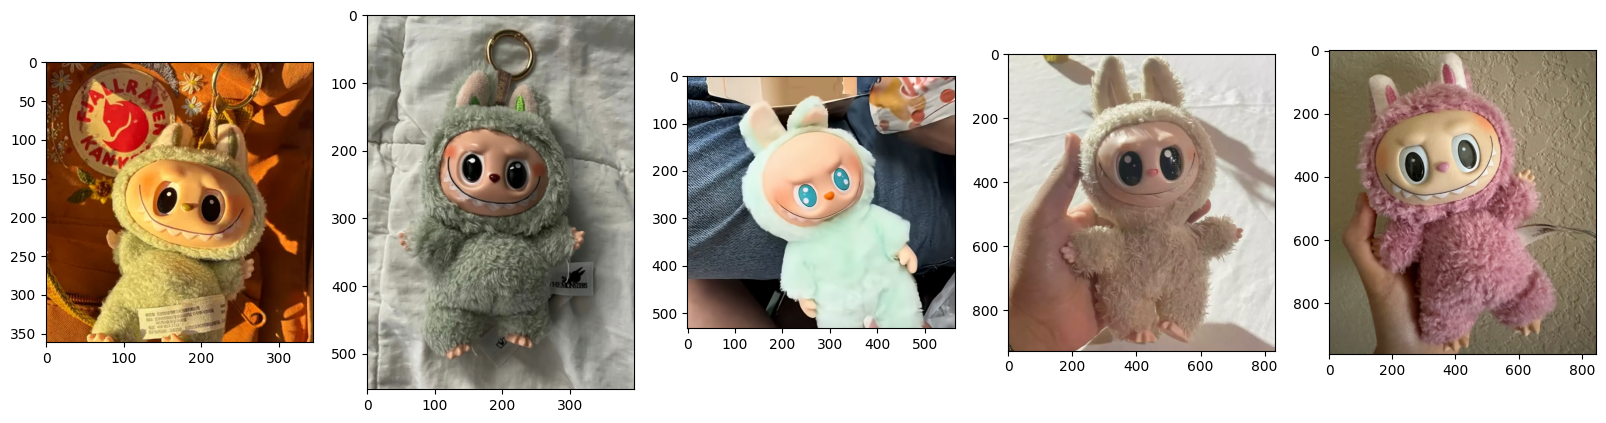

In [72]:
plot_images(fake_images) # these are images of FAKE Labubus

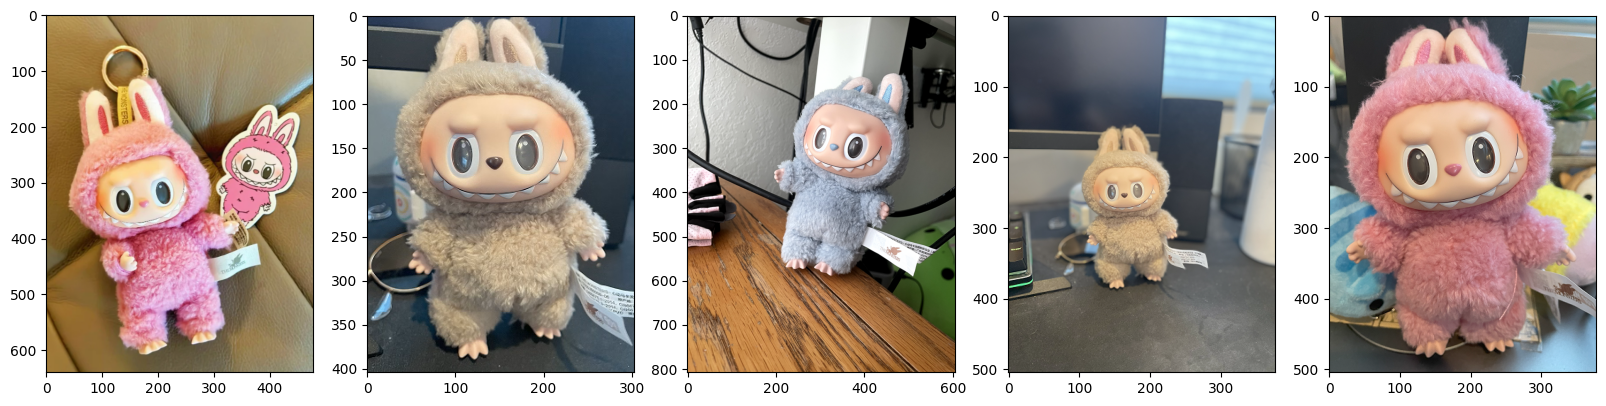

In [71]:
plot_images(real_images) # these are images of REAL Labubus

Feature-wise, we can see that the fake Labubus have some combination of different face shape, different face texture, and coloring (especially in/around the eyes) compared to the real Labubus. The last fake image on the right looks almost real, but notice the visible stitching around the edge of the Labubus face that's not present in any of the real Labubus. Some Labubus, like fake images #1, #3, #4, are more obvious fakes while images #2 and #5 are more subtle and may require a more trained eye.

Importantly, we can see the images are not all the same size. Our CNN model is going to require these images be of the same size, so we'll need to do some image processing.

### Image resizing
First we'll need to determine the ideal size to resize all of our images to. I'll start by plotting the dimensions (width & height) of the images. It makes sense for me to choose a final size somewhere in the average of the image sizes, but I also want to avoid deforming or losing too much of any image by resizing too drastically.

In [8]:
def get_dims(images):
    """
    Writes the widths and heights of a given set of images to a dataframe

    Args: 
        images: list of images stored as numpy arrays

    Returns:
        Pandas dataframe consisting of images' widths and heights
    """
    dim_list = []

    for idx, img in enumerate(images):
        dim_list.append([img.shape[1], img.shape[0]]) # [width, height]
    
    return pd.DataFrame(dim_list, columns = ['width', 'height'])

In [9]:
fake_dims = get_dims(fake_images)
fake_dims.insert(2, 'image_type', 'fake')

real_dims = get_dims(real_images)
real_dims.insert(2, 'image_type', 'real')

all_dims = pd.concat([fake_dims, real_dims], axis = 0, ignore_index = True)

In [10]:
all_dims.describe()

width       height
count  200.000000   200.000000
mean   580.180000   688.915000
std    116.411839   142.816704
min    187.000000   297.000000
25%    516.000000   563.750000
50%    605.000000   692.500000
75%    626.500000   807.000000
max    912.000000  1041.000000

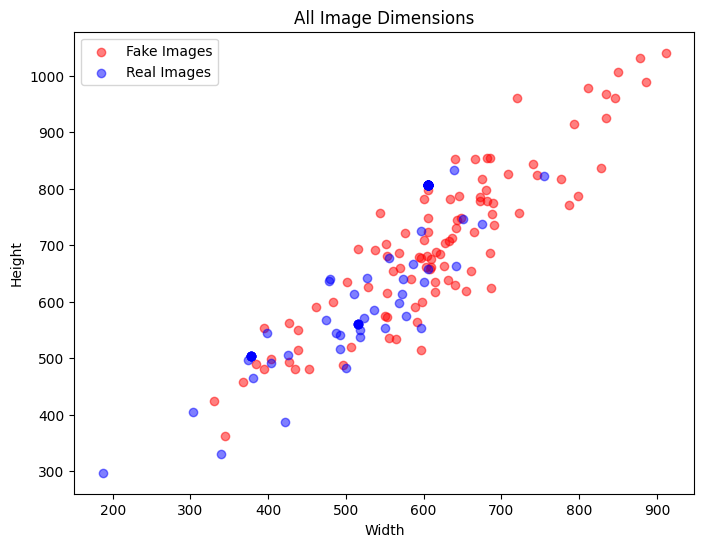

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

ax.scatter(fake_dims['width'], fake_dims['height'], color = 'r', label = 'Fake Images', alpha = 0.5)
ax.scatter(real_dims['width'], real_dims['height'], color = 'b', label = 'Real Images', alpha = 0.5)
ax.set_title('All Image Dimensions')
ax.set_xlabel('Width')
ax.set_ylabel('Height')
ax.legend()

plt.show()

x_lim = ax.get_xlim() # save current x axis
y_lim = ax.get_ylim() # save current y axis

We can see for both fake & real images, sizes vary between about 200-900px in width, and 300-1000px in height. This is quite a large range, and I'll be using CV2 library's image resize function to get the images closer in size to each other without affecting the image's scale. Then, I'll be doing manual cropping to get the images to make the final size adjustments.

In [12]:
def resize_img(img, factor):
    """
    Resizes an image based on a multiplicative factor applied to width & height

    Args: 
        img: image stored in Numpy array of RGB pixel values
        factor: multiplicative factor to apply to width & height, can be positive or negative

    Returns:
        New resized image stored as a numpy array
    """
    new_size = (round(img.shape[1] * (1 + factor)), round(img.shape[0] * (1 + factor)))
    
    return cv2.resize(img, new_size)

In [13]:
all_dims.describe()

width       height
count  200.000000   200.000000
mean   580.180000   688.915000
std    116.411839   142.816704
min    187.000000   297.000000
25%    516.000000   563.750000
50%    605.000000   692.500000
75%    626.500000   807.000000
max    912.000000  1041.000000

This block of code resizes all images with width less than 500 to be equal to 500. Height after resizing is free to vary based on the image's original scale.

In [14]:
img_idx = all_dims[all_dims['width'] < 500].index

for i in img_idx:
    resize_factor = 500 / all_images[i].shape[1] - 1 # 500 divided by current width minus 1
    all_images[i] = resize_img(all_images[i], resize_factor)
    all_dims.iloc[i, 0] = all_images[i].shape[1] # record new width
    all_dims.iloc[i, 1] = all_images[i].shape[0] # record new height

Below block of code resizes all images with width over 660 to be equal to 660. Height after resizing again is free to vary based on the image's original scale.

In [15]:
img_idx = all_dims[all_dims['width'] > 660].index

for i in img_idx:
    resize_factor = 660 / all_images[i].shape[1] - 1 # 660 divided by current width minus 1
    all_images[i] = resize_img(all_images[i], resize_factor)
    all_dims.iloc[i, 0] = all_images[i].shape[1] # record new width
    all_dims.iloc[i, 1] = all_images[i].shape[0] # record new height

In [16]:
all_dims.describe()

width      height
count  200.00000  200.000000
mean   584.15500  696.420000
std     57.50937   96.047903
min    500.00000  460.000000
25%    516.00000  625.750000
50%    605.00000  690.000000
75%    626.50000  807.000000
max    660.00000  880.000000

In [65]:
# update fake and real dims, to provide labels to below chart
fake_dims = all_dims[all_dims['image_type'] == 'fake']
real_dims = all_dims[all_dims['image_type'] == 'real']

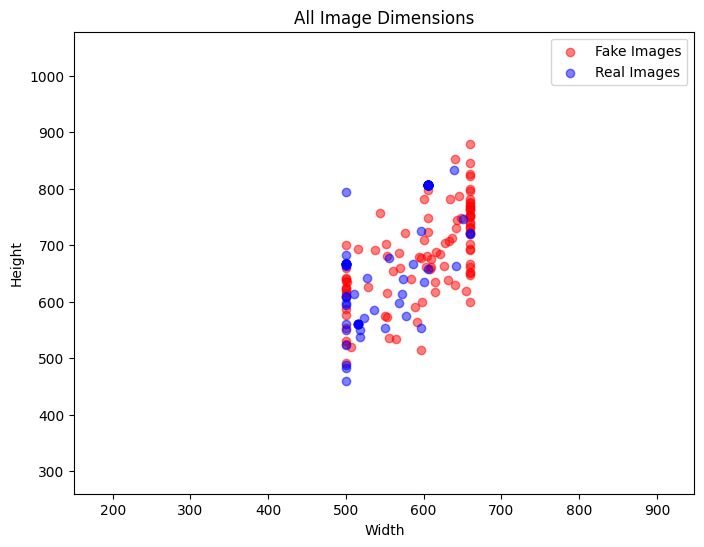

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

ax.scatter(fake_dims['width'], fake_dims['height'], color = 'r', label = 'Fake Images', alpha = 0.5)
ax.scatter(real_dims['width'], real_dims['height'], color = 'b', label = 'Real Images', alpha = 0.5)
ax.set_title('All Image Dimensions')
ax.set_xlabel('Width')
ax.set_xlim(x_lim)
ax.set_ylabel('Height')
ax.set_ylim(y_lim)
ax.legend()

plt.show()

Now we can see image dimensions stay within a much smaller range than before. Images that were resized are easily identified as lying along the vertical lines x = 500 and x = 660, as those images' widths were set equal to those values while height varied based on the image's scale. The rest of the resizing will be done via manual cropping.

### Image cropping

There's a few ways to go about cropping and I chose the approach of cropping all images down to the **minimum** dimensions seen in the dataset, which is 500px width x 460px height.

In [19]:
def get_min_dims(images):
    """
    Returns the minimum height and width of a set of images

    Args: 
        images: list of images stored as numpy arrays

    Returns:
        (min_height, min_width)
    """
    img_dims = np.zeros(shape = (len(images), 2))
    
    for idx, r in enumerate(images):
        img_dims[idx] = [r.shape[0], r.shape[1]] # [height, width]
    
    return (np.min(img_dims[:, 0]), np.min(img_dims[:, 1]))

def crop_image(img, height, width):
    """ Crop an image around the center to specified dimensions

    Args:
        img: image to crop stored as numpy array
        height: desired height after cropping
        width: desired width after cropping

    Returns:
        cropped image as a numpy array
    """
    
    height_mid = img.shape[0] // 2
    width_mid = img.shape[1] // 2
    
    if height % 2 == 0: # is even
        h_offset_pos = h_offset_neg = height / 2
    else: # is odd
        h_offset_pos = (height // 2) + 1
        h_offset_neg = height // 2
    
    if width % 2 == 0: # is even
        w_offset_pos = w_offset_neg = width / 2
    else: # is odd
        w_offset_pos = (width // 2) + 1
        w_offset_neg = width // 2
    
    bottom = int(height_mid - h_offset_neg)
    top = int(height_mid + h_offset_pos)
    
    left = int(width_mid - w_offset_neg)
    right = int(width_mid + w_offset_pos)
    
    return img[bottom:top, left:right, :].astype(int)

def crop_images_to_min(images):
    """ 
    Crop a set of images so that they all have the same dimensions. 
    The cropped dimensions will be based on the minimum dimensions of images in the set.

    Args:
        images: list of images stored as numpy arrays

    Returns:
        cropped list of images stored as numpy arrays
    """

    h_min, w_min = get_min_dims(images)
    h_min = int(h_min)
    w_min = int(w_min)
    
    cropped_images = np.zeros(shape = (len(images), h_min, w_min, 3))

    for idx, img in enumerate(images):
        cropped_images[idx] = crop_image(img, h_min, w_min)

    return cropped_images.astype(int)

In [68]:
all_images_cropped = crop_images_to_min(all_images)
all_images_cropped[0].shape # confirm that images have been cropped to 460 x 500 (CV2 outputs height x width)

(460, 500, 3)

### Sample the resized images

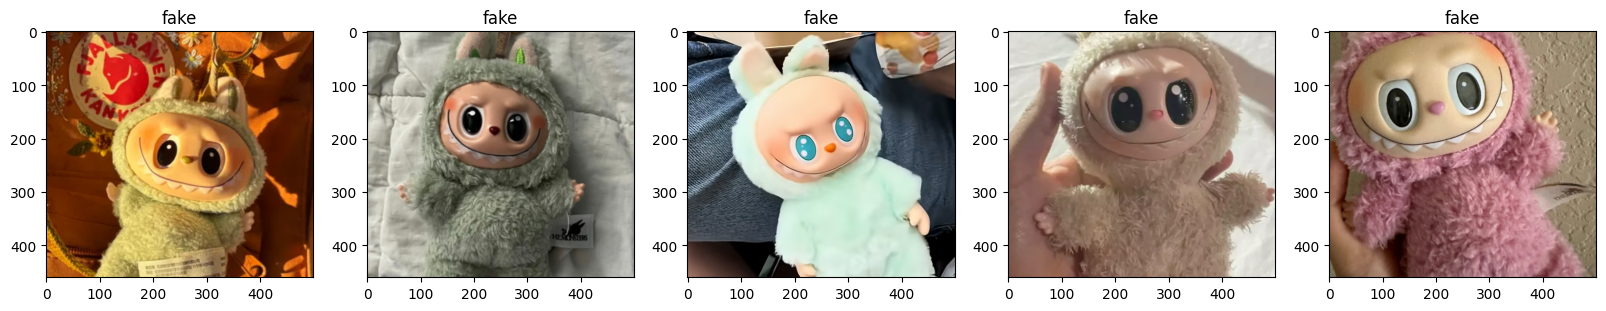

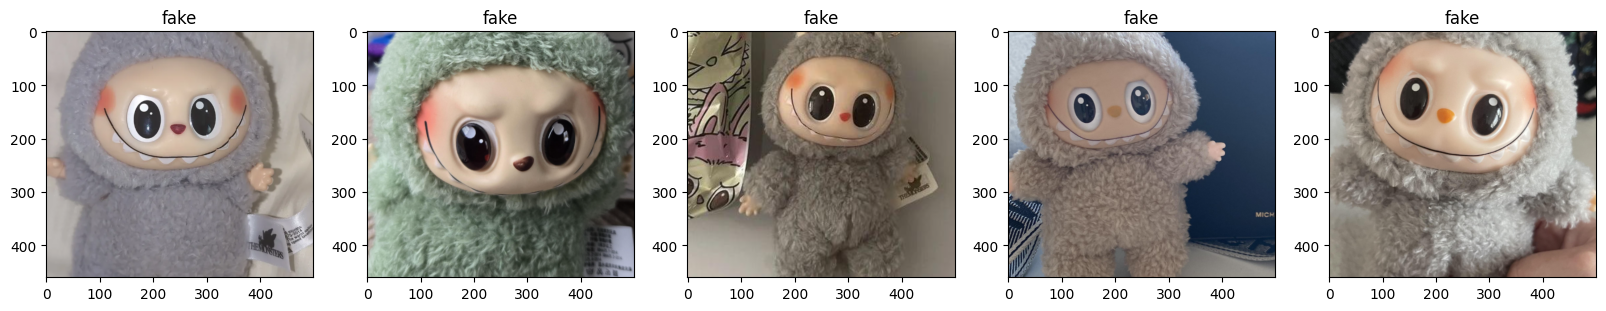

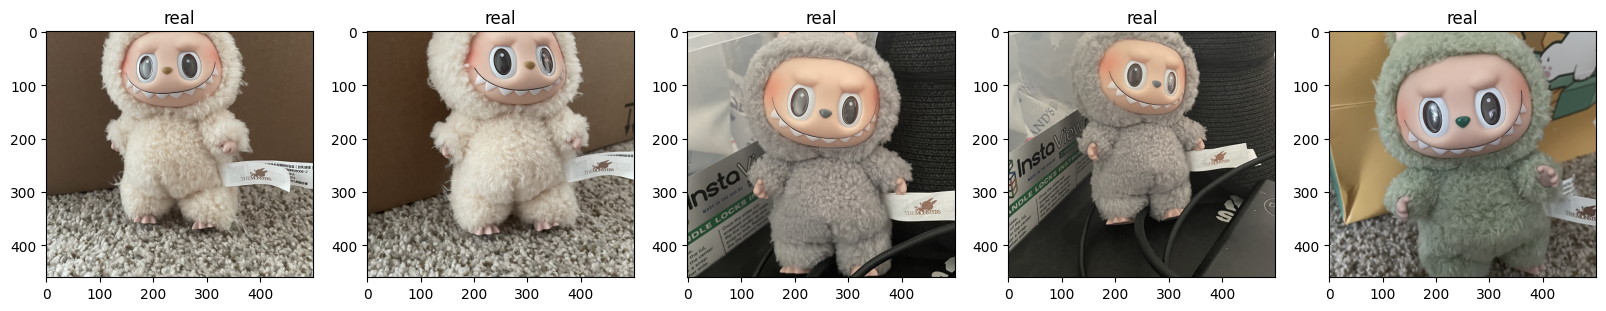

In [22]:
plot_images(all_images_cropped[0:5], labels = all_dims.iloc[0:5, 2].values)
plot_images(all_images_cropped[88:93], labels = all_dims.iloc[88:93, 2].values)
plot_images(all_images_cropped[183:188], labels = all_dims.iloc[183:188, 2].values)

All images have been resized to the same dimensions. A few images have had some side cut off, which is an unfortunate side effect of cropping to the same size of the smallest image in the dataset. Other approaches would be cropping to the average size, which would require black boxes of varying sizes added to sides of the smaller images. It is worth trying as a follow-up exercise for this project to see if that allows for better model performance.

### Standardize image pixel data

Here we'll standardize the image data by subtracting the mean pixel value from all values, and dividing by the standard deviation. The net effect is that the mean of all pixel values for each image will be 0, and the standard deviation will be 1. Having smaller numeric values generally lead to better performance for CNN models.

In [23]:
all_images_cropped_std = np.zeros(shape = all_images_cropped.shape)

for i, idx in enumerate(all_images_cropped):
    all_images_cropped_std[i] = (all_images_cropped[i] - np.mean(all_images_cropped[i])) / np.std(all_images_cropped[i])

In [69]:
all_images_cropped_std.shape

(200, 460, 500, 3)

### Split into train, validation, test

There's 200 total images. I'll be splitting off 60% for training, 20% for validation, and 20% for test. The CNN models will be evaluated during the training phase on how well they fit the training & validation data. Afterwards, the final evaluation will be on the test dataset which, up to that point, will be completely unseen data for the models.

In [25]:
np.random.seed(999)
labels = all_dims['image_type'].map({'fake': 1, 'real': 0})

images_n = all_images_cropped_std.shape[0]
r_ind = np.random.choice(images_n, 40, replace = False)

valid_data = all_images_cropped_std[r_ind]
valid_labels = labels[r_ind].values

remaining_data = np.delete(all_images_cropped_std, r_ind, axis = 0)
remaining_labels = np.delete(labels, r_ind, axis = 0)

images_n = remaining_data.shape[0]
r_ind = np.random.choice(images_n, 40, replace = False)

test_data = remaining_data[r_ind]
test_labels = remaining_labels[r_ind]

train_data = np.delete(remaining_data, r_ind, axis = 0)
train_labels = np.delete(remaining_labels, r_ind, axis = 0)

In [26]:
np.unique(train_labels, return_counts = True)

(array([0, 1]), array([56, 64]))

In [27]:
np.unique(valid_labels, return_counts = True)

(array([0, 1]), array([21, 19]))

In [28]:
np.unique(test_labels, return_counts = True)

(array([0, 1]), array([23, 17]))

### Shuffle training data

The final step will be shuffling the training data so it's fed into the Keras models in a random sequence. I found this step necessary to get the best performance from the models, to minimize instances of similar training images to be fed into the model sequentially and exacerbating overfitting issues.

In [29]:
p = np.random.permutation(len(train_data))
train_data = train_data[p]
train_labels = train_labels[p]

# Building a CNN Model
I'll trial 6 different model architectures and plot their training and validation accuracies. The primary metric used to compare these models is validation accuracy, since I want a model that can generalize well to unseen data.

### V1 Model: 3-Conv > Max Pool > Dense

This is a simple CNN architecture to start with, and one which performed well on Week 3's cancer detection project. There are many parameters (129 million), which is likely overkill here as I have much less training images than during the cancer detection project however.

In [30]:
model_v1 = Sequential()
model_v1.add(Conv2D(filters = 3, kernel_size = (3, 3), activation = 'relu'))
model_v1.add(Conv2D(filters = 6, kernel_size = (3, 3), activation = 'relu'))
model_v1.add(Conv2D(filters = 9, kernel_size = (3, 3), activation = 'relu'))
model_v1.add(MaxPooling2D(strides = 2))
model_v1.add(Flatten())
model_v1.add(Dense(units = 256, activation = 'relu'))
model_v1.add(Dense(units = 1, activation = 'sigmoid'))

model_v1.build((1, 460, 500, 3))
model_v1.compile('adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'auc'])

In [31]:
model_v1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (1, 458, 498, 3)            │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1, 456, 496, 6)            │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (1, 454, 494, 9)            │             495 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 227, 247, 9)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 504621)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 256)                    │     129,183,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,184,236 (492.80 MB)

 Trainable params: 129,184,236 (492.80 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
es = EarlyStopping(verbose = 1, patience = 10, monitor = 'val_accuracy', restore_best_weights = True)
rl = ReduceLROnPlateau(verbose = 1)

results_v1 = model_v1.fit(x = train_data, y = train_labels, epochs = 50, validation_data = (valid_data, valid_labels), callbacks = [es, rl])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4548 - auc: 0.4619 - loss: 11.8054 - val_accuracy: 0.5250 - val_auc: 0.5000 - val_loss: 28.7812 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4602 - auc: 0.5172 - loss: 26.1238 - val_accuracy: 0.4750 - val_auc: 0.5000 - val_loss: 10.8415 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7015 - auc: 0.7318 - loss: 3.7348 - val_accuracy: 0.5750 - val_auc: 0.5789 - val_loss: 9.9926 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7935 - auc: 0.8736 - loss: 1.8988 - val_accuracy: 0.6750 - val_auc: 0.7268 - val_loss: 3.5969 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8498 - auc: 0.8888 - loss: 1.1802 - val_accuracy: 0.5250 - val_auc: 0.6667 - val_loss: 5.7301 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9098 - auc: 0.9532 - loss: 0.5188 - va

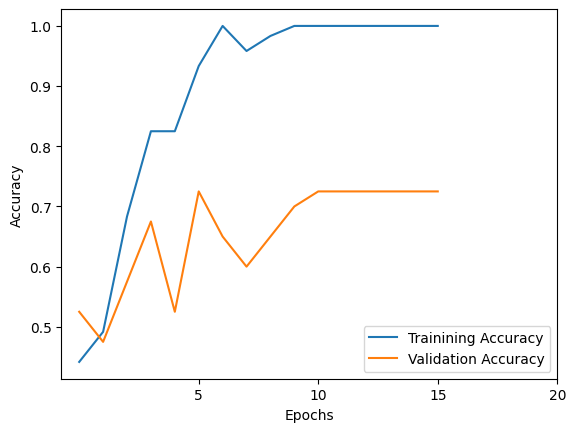

In [58]:
# Plot training and validation accuracies
plt.plot(results_v1.history['accuracy'], label = 'Trainining Accuracy')
plt.plot(results_v1.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(ticks = [5, 10, 15, 20])
plt.show()

Training accuracy gets to 100% quickly while validation accuracy plateaus at 72%. It's likely overfitting the training dataset, which I feel is quite easy to do since there's not a lot of training data.

### V2 Model: More Max Pooling

By using more max pooling layers (between each convolutional layer), we can reduce the feature map dimensions more quickly and greatly reduce the number of parameters in the model which may help reduce overfitting.

In [34]:
model_v2 = Sequential()
model_v2.add(Conv2D(filters = 3, kernel_size = (3, 3), activation = 'relu'))
model_v2.add(MaxPooling2D(strides = 2))
model_v2.add(Conv2D(filters = 6, kernel_size = (3, 3), activation = 'relu'))
model_v2.add(MaxPooling2D(strides = 2))
model_v2.add(Conv2D(filters = 9, kernel_size = (3, 3), activation = 'relu'))
model_v2.add(MaxPooling2D(strides = 2))
model_v2.add(Flatten())
model_v2.add(Dense(units = 256, activation = 'relu'))
model_v2.add(Dense(units = 1, activation = 'sigmoid'))

model_v2.build((1, 460, 500, 3))
model_v2.compile('adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'auc'])

In [35]:
model_v2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (1, 458, 498, 3)            │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1, 229, 249, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (1, 227, 247, 6)            │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 113, 123, 6)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (1, 111, 121, 9)            │             495 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (1, 55, 60, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (1, 29700)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 256)                    │       7,603,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 1)                      │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,604,460 (29.01 MB)

 Trainable params: 7,604,460 (29.01 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
es = EarlyStopping(verbose = 1, patience = 10, monitor = 'val_accuracy', restore_best_weights = True)
rl = ReduceLROnPlateau(verbose = 1)

results_v2 = model_v2.fit(x = train_data, y = train_labels, epochs = 50, validation_data = (valid_data, valid_labels), callbacks = [es, rl])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - accuracy: 0.4056 - auc: 0.4293 - loss: 7.9706 - val_accuracy: 0.4750 - val_auc: 0.5464 - val_loss: 3.2895 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.5456 - auc: 0.4826 - loss: 2.4130 - val_accuracy: 0.4750 - val_auc: 0.6429 - val_loss: 0.8263 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.5265 - auc: 0.5915 - loss: 0.7505 - val_accuracy: 0.5250 - val_auc: 0.4925 - val_loss: 1.0138 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.4556 - auc: 0.6506 - loss: 0.9438 - val_accuracy: 0.5250 - val_auc: 0.5664 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.6471 - auc: 0.6889 - loss: 0.6616 - val_accuracy: 0.4750 - val_auc: 0.6792 - val_loss: 0.8125 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.5263 - auc: 0.8771 - loss:

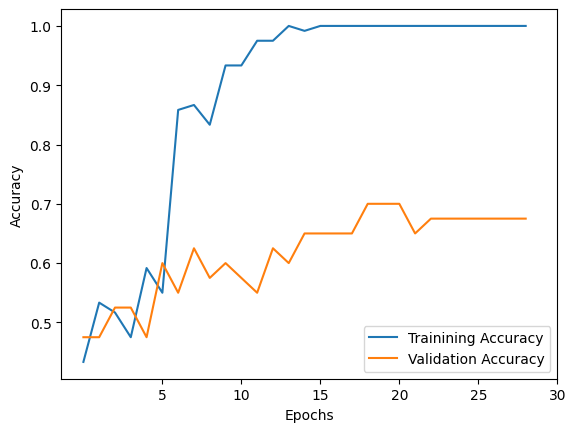

In [59]:
# Plot training and validation accuracies
plt.plot(results_v2.history['accuracy'], label = 'Trainining Accuracy')
plt.plot(results_v2.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(ticks = [5, 10, 15, 20, 25, 30])
plt.show()

This model took more epochs to get close to 100% training accuracy than V1, but still shows signs of overfitting and validation accuracy struggles to surpass 70%.

### V3 Model: More max pooling & ConvLayers with stride 2

By using strides of 2 for the conv layers, we halve the output feature map dimension an additional time between convolutional layers. This further reducing the number of model parameters and hopefully curbs overfitting.

In [38]:
model_v3 = Sequential()
model_v3.add(Conv2D(filters = 3, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v3.add(MaxPooling2D(strides = 2))
model_v3.add(Conv2D(filters = 6, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v3.add(MaxPooling2D(strides = 2))
model_v3.add(Conv2D(filters = 9, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v3.add(MaxPooling2D(strides = 2))
model_v3.add(Flatten())
model_v3.add(Dense(units = 256, activation = 'relu'))
model_v3.add(Dense(units = 1, activation = 'sigmoid'))

model_v3.build((1, 460, 500, 3))
model_v3.compile('adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'auc'])

In [39]:
model_v3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (1, 229, 249, 3)            │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (1, 114, 124, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (1, 56, 61, 6)              │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (1, 28, 30, 6)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (1, 13, 14, 9)              │             495 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (1, 6, 7, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 378)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 256)                    │          97,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 1)                      │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,028 (382.92 KB)

 Trainable params: 98,028 (382.92 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
es = EarlyStopping(verbose = 1, patience = 10, monitor = 'val_accuracy', restore_best_weights = True)
rl = ReduceLROnPlateau(verbose = 1)

results_v3 = model_v3.fit(x = train_data, y = train_labels, epochs = 50, validation_data = (valid_data, valid_labels), callbacks = [es, rl])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5331 - auc: 0.5514 - loss: 0.6924 - val_accuracy: 0.5250 - val_auc: 0.6566 - val_loss: 0.6865 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6798 - auc: 0.8250 - loss: 0.6213 - val_accuracy: 0.7000 - val_auc: 0.7130 - val_loss: 0.6478 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8677 - auc: 0.9464 - loss: 0.5525 - val_accuracy: 0.7000 - val_auc: 0.7569 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8775 - auc: 0.9691 - loss: 0.4880 - val_accuracy: 0.6500 - val_auc: 0.7569 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9392 - auc: 0.9747 - loss: 0.4012 - val_accuracy: 0.7000 - val_auc: 0.7694 - val_loss: 0.5917 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9742 - auc: 0.9854 - loss: 0.3

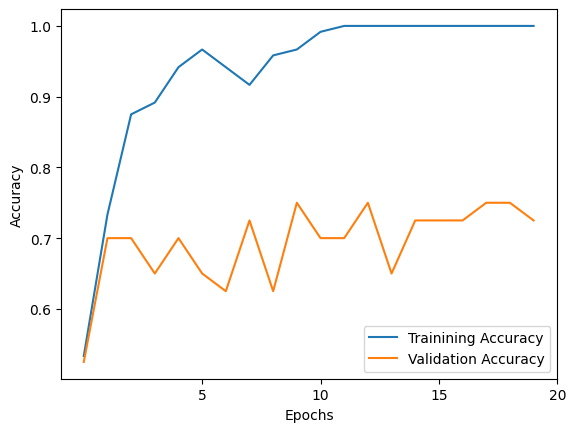

In [60]:
# Plot training and validation accuracies
plt.plot(results_v3.history['accuracy'], label = 'Trainining Accuracy')
plt.plot(results_v3.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(ticks = [5, 10, 15, 20])
plt.show()

Overfitting problem is still present. However this model reached 70% validation accuracy more quickly than the models so far. It appears that using 2 strides in the convolutiona layers didn't negatively impact the model's ability to detect the fake labubu's and generalize to the validation data.

### V4 Model: Adding Image Augmentation

Oftentimes, image augmentation can help the model to generalize better as it introduces more diversity to the training dataset. In this case, I'm using RandomFlip and RandomRotation layers at the beginning to alter the training images randomly as they're fed into the model. The degree of rotation is only +/- 20 degrees, so that the altered images are still realistic training images and not too far changed.

In [42]:
model_v4 = Sequential()
model_v4.add(RandomFlip(mode = "horizontal"))
model_v4.add(RandomRotation(factor = 0.2, fill_mode = 'reflect'))
model_v4.add(Conv2D(filters = 3, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v4.add(MaxPooling2D(strides = 2))
model_v4.add(Conv2D(filters = 6, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v4.add(MaxPooling2D(strides = 2))
model_v4.add(Conv2D(filters = 9, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v4.add(MaxPooling2D(strides = 2))
model_v4.add(Flatten())
model_v4.add(Dense(units = 256, activation = 'relu'))
model_v4.add(Dense(units = 1, activation = 'sigmoid'))

model_v4.build((1, 460, 500, 3))
model_v4.compile('adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'auc'])

es = EarlyStopping(verbose = 1, patience = 10, monitor = 'val_accuracy', restore_best_weights = True)
rl = ReduceLROnPlateau(verbose = 1)

results_v4 = model_v4.fit(x = train_data, y = train_labels, epochs = 50, validation_data = (valid_data, valid_labels), callbacks = [es, rl])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - accuracy: 0.4106 - auc: 0.4624 - loss: 0.8068 - val_accuracy: 0.4750 - val_auc: 0.6792 - val_loss: 0.7441 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.5838 - auc: 0.6397 - loss: 0.6526 - val_accuracy: 0.4750 - val_auc: 0.4424 - val_loss: 0.7081 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.5194 - auc: 0.6005 - loss: 0.7022 - val_accuracy: 0.4750 - val_auc: 0.4198 - val_loss: 0.7114 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.5283 - auc: 0.6051 - loss: 0.6963 - val_accuracy: 0.5250 - val_auc: 0.5226 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.5698 - auc: 0.5929 - loss: 0.6792 - val_accuracy: 0.5250 - val_auc: 0.6178 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.5412 - auc: 0.6689 - loss:

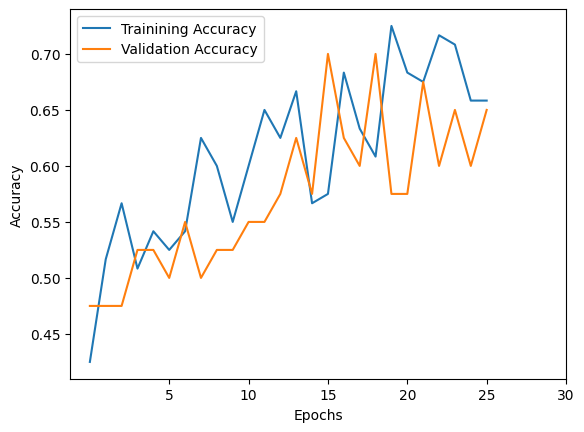

In [61]:
# Plot training and validation accuracies
plt.plot(results_v4.history['accuracy'], label = 'Trainining Accuracy')
plt.plot(results_v4.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(ticks = [5, 10, 15, 20, 25, 30])
plt.show()

Image augmentation definitely reduced the model's accuracy on the training data, but unfortunately also negatively impacted validation accuracy. I would have liked to see lower training accuracy while retaining or increasing validation accuracy, which would indicate a reduction in the overfitting issue.

### V5 Model: V3 Model w/ Dropout Layer

We're going to step back from using image augmentation, and instead utilize a dropout layer between the Dense layer and output layer to help with generalization and overfitting.

In [44]:
model_v5 = Sequential()
model_v5.add(Conv2D(filters = 3, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v5.add(MaxPooling2D(strides = 2))
model_v5.add(Conv2D(filters = 6, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v5.add(MaxPooling2D(strides = 2))
model_v5.add(Conv2D(filters = 9, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v5.add(MaxPooling2D(strides = 2))
model_v5.add(Flatten())
model_v5.add(Dense(units = 256, activation = 'relu'))
model_v5.add(Dropout(rate = 0.5))
model_v5.add(Dense(units = 1, activation = 'sigmoid'))

model_v5.build((1, 460, 500, 3))
model_v5.compile('adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'auc'])

In [45]:
model_v5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (1, 229, 249, 3)            │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (1, 114, 124, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (1, 56, 61, 6)              │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (1, 28, 30, 6)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (1, 13, 14, 9)              │             495 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (1, 6, 7, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (1, 378)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 256)                    │          97,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 1)                      │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,028 (382.92 KB)

 Trainable params: 98,028 (382.92 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
es = EarlyStopping(verbose = 1, patience = 10, monitor = 'val_accuracy', restore_best_weights = True)
rl = ReduceLROnPlateau(verbose = 1)

results_v5 = model_v5.fit(x = train_data, y = train_labels, epochs = 50, validation_data = (valid_data, valid_labels), callbacks = [es, rl])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.5375 - auc: 0.5582 - loss: 0.6839 - val_accuracy: 0.5000 - val_auc: 0.6416 - val_loss: 0.6706 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6994 - auc: 0.7401 - loss: 0.6314 - val_accuracy: 0.5750 - val_auc: 0.7519 - val_loss: 0.6503 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6356 - auc: 0.6895 - loss: 0.6398 - val_accuracy: 0.6250 - val_auc: 0.8020 - val_loss: 0.6328 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7117 - auc: 0.8161 - loss: 0.5964 - val_accuracy: 0.6750 - val_auc: 0.8145 - val_loss: 0.6055 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7750 - auc: 0.8460 - loss: 0.5518 - val_accuracy: 0.6500 - val_auc: 0.8083 - val_loss: 0.5800 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7996 - auc: 0.9041 - loss: 0.48

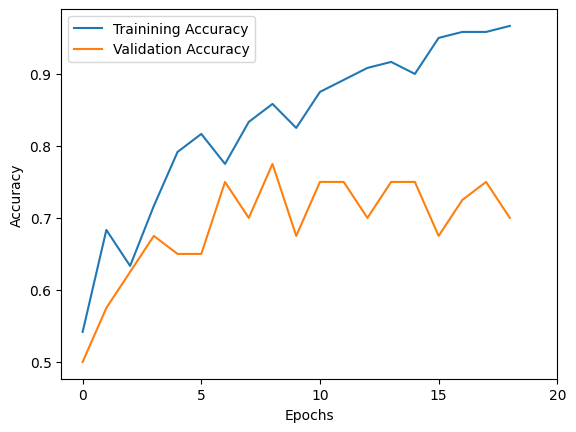

In [62]:
# Plot training and validation accuracies
plt.plot(results_v5.history['accuracy'], label = 'Trainining Accuracy')
plt.plot(results_v5.hifetory['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(ticks = [0, 5, 10, 15, 20])
plt.show()

This is the first model which appears to have helped the overfitting issue. Training accuracy is not ridiculously high, and validation accuracy is retained around 70% as with other models. It's possible that this model will generalize better to completely unseen test data later on in model evaluation.

### V6 Model: V3 Model w/ additional Dense and Dropout layers

Since we had some positive results with using 1 dropout layer, let's use 2! This will require an additional dense layer added after the last pooling layer.

In [48]:
model_v6 = Sequential()
model_v6.add(Conv2D(filters = 3, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v6.add(MaxPooling2D(strides = 2))
model_v6.add(Conv2D(filters = 6, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v6.add(MaxPooling2D(strides = 2))
model_v6.add(Conv2D(filters = 9, kernel_size = (3, 3), strides = 2, activation = 'relu'))
model_v6.add(MaxPooling2D(strides = 2))
model_v6.add(Flatten())
model_v6.add(Dense(units = 256, activation = 'relu'))
model_v6.add(Dropout(rate = 0.5))
model_v6.add(Dense(units = 128, activation = 'relu'))
model_v6.add(Dropout(rate = 0.5))
model_v6.add(Dense(units = 1, activation = 'sigmoid'))

model_v6.build((1, 460, 500, 3))
model_v6.compile('adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'auc'])

In [49]:
es = EarlyStopping(verbose = 1, patience = 10, restore_best_weights = True)
rl = ReduceLROnPlateau(verbose = 1)

results_v6 = model_v6.fit(x = train_data, y = train_labels, epochs = 50, validation_data = (valid_data, valid_labels), callbacks = [es, rl])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.4883 - auc: 0.4614 - loss: 0.7499 - val_accuracy: 0.4000 - val_auc: 0.4812 - val_loss: 0.6977 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5288 - auc: 0.5840 - loss: 0.6877 - val_accuracy: 0.5000 - val_auc: 0.5501 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6140 - auc: 0.6252 - loss: 0.6638 - val_accuracy: 0.4500 - val_auc: 0.5952 - val_loss: 0.6865 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6177 - auc: 0.6516 - loss: 0.6600 - val_accuracy: 0.5750 - val_auc: 0.6128 - val_loss: 0.6808 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6719 - auc: 0.7091 - loss: 0.6395 - val_accuracy: 0.5750 - val_auc: 0.6216 - val_loss: 0.6763 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6648 - auc: 0.6928 - loss: 0.63

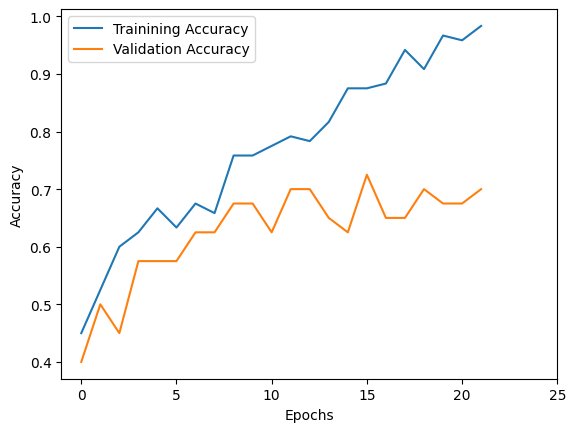

In [63]:
# Plot training and validation accuracies
plt.plot(results_v6.history['accuracy'], label = 'Trainining Accuracy')
plt.plot(results_v6.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(ticks = [0, 5, 10, 15, 20, 25])
plt.show()

Validation accuracy dropped slightly below what we had with Model V5, and it's questionable if the additional dropout layer was useful for the model.

# Model Evaluation on Test Data
Let's see how each model performs on the 20% of data held out for test, which up to now is completely unseen data. Recall the test data is fairly well balanced - with 23 real images & 17 fake.

In [51]:
def evaluate(model, data = test_data, labels = test_labels, print_output = False):
    """
    Computes evaluation metrics for a given model and labeled dataset.

    Args: 
        model: Keras model to evaluate
        data: Data the model should make predictions on
        labels: Actual labels for the data, to evaluate the model's predictions against
        print_output: If confusion matrix and scores should be printed

    Returns:
        NumPy array: [accuracy, precision, recall, F1 score]
    """
    proba = model.predict(x = data).reshape(-1)
    pred = np.round(proba).astype(int)

    tp, tn, fp, fn = 0, 0, 0, 0

    for i, p in enumerate(pred):
        if pred[i] == 1 and test_labels[i] == 1:
            tp += 1
        elif pred[i] == 1 and test_labels[i] == 0:
            fp += 1
        elif pred[i] == 0 and test_labels[i] == 1:
            fn += 1
        elif pred[i] == 0 and test_labels[i] == 0:
            tn += 1
        else:
            raise Exception("Invalid Case")
            
    acc = (tp+tn) / (tp+fp+fn+tn)
    pre = tp / (tp+fp)
    rec = tp / (tp+fn)
    f = (2*pre*rec) / (pre + rec)

    if (print_output):
        print(f"Confusion Matrix:\n {np.array([[tp, fp], [fn, tn]])} \n")
        print("Accuracy:", np.round(acc, 2))
        print("Precision:", np.round(pre, 2))
        print("Recall:", np.round(rec, 2))
        print("F1:", np.round(f, 2))

    return np.array([np.round(acc, 3), np.round(pre, 3), np.round(rec, 3), np.round(f, 3)])

In [57]:
scores = evaluate(model_v1)
scores = np.vstack([scores, evaluate(model_v2)])
scores = np.vstack([scores, evaluate(model_v3)])
scores = np.vstack([scores, evaluate(model_v4)])
scores = np.vstack([scores, evaluate(model_v5)])
scores = np.vstack([scores, evaluate(model_v6)])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [53]:
names = ['model_v1', 'model_v2', 'model_v3', 'model_v4', 'model_v5', 'model_v6']
evals = pd.DataFrame({'model':names, 'accuracy':scores[:,0], 'precision':scores[:,1], 'recall':scores[:,2], 'f1':scores[:,3]})
evals

model  accuracy  precision  recall     f1
0  model_v1     0.625      0.542   0.765  0.634
1  model_v2     0.575      0.500   0.882  0.638
2  model_v3     0.600      0.522   0.706  0.600
3  model_v4     0.525      0.438   0.412  0.424
4  model_v5     0.725      0.875   0.412  0.560
5  model_v6     0.650      0.600   0.529  0.562

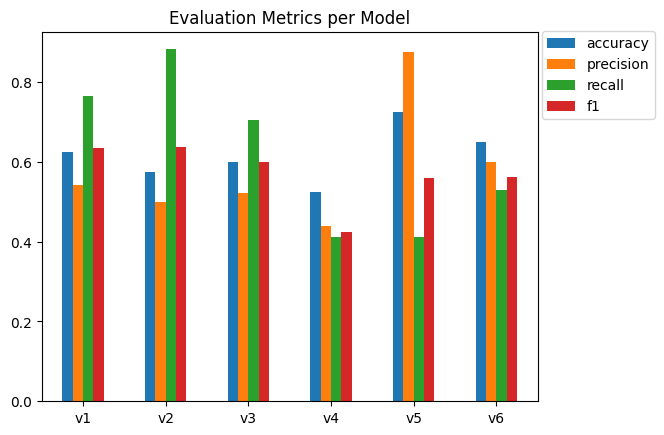

In [54]:
ax = evals.plot.bar()
ax.set_title('Evaluation Metrics per Model')
ax.set_xticks(ticks = [0, 1, 2, 3, 4, 5], labels = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6'], rotation = 0)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.25, 1.02))
plt.show()

The purpose of this model is to help identify when a labubu is fake, in order to protect consumers from getting scammed. It is important, then, for the model to minimize false negatives i.e., failing to flag a fake labubu. Not being able to identify the fakes would quickly cause users to lose trust in the model. On the other hand, false positives (flagging a labubu as fake when its real), would not be as bad. In other words, it's better for the model to be overly strict and flag too many fakes, compared to being too lax and failing to flag a lot of fakes. For that reason, we prefer a model with high **recall**, without sacrificing too much **accuracy**.

Unfortunately most of the models' test accuracy was around 60% which is less than ideal. **Model 5** has the highest test accuracy (73%), but low recall (41%) which is an important metric for us. **Model 1** had relatively decent test accuracy and a high recall of 77%. **Model 2** had quite high recall (88%) but lower accuracy and precision, which means it's flagging a lot of false positives.

Given these scores, I'd choose **Model 1** as the best performing out of these 6 for our purposes, with Model 2 following close behind.

# Conclusion

The best model chosen is able to classify real vs fake Labubus with 63% accuracy. This is lower than I hoped, but better than random guessing which would amount to around 50% accuracy on the test dataset. One major difficulty in this **project was a small training dataset of only 120 images**. Classifying fake Labubus can come down to subtle queues such as stitching patterns, differing shapes, and non-uniform edges. For a model to detect these I'd expect it need at least thousands of training images - more than I have time to collect & label. Additionally, since there are multiple styles & colors of real Labubus, the training dataset would need to have good representation of all types.

Since the **validation and test sets were also small** (40 images each), the respective accuracies fluctuated quite a bit. A model that classifies just 2 more images correctly than another would score a 5% higher accuracy. A larger test set would allow for more robust test numbers that are unlikely to change due to random chance. I felt that perhaps a model other than V1 would perform better on a larger and more varied validation & test datasets.

**Overfitting** and **ability to generalize** was a major issue for the models I tried, to varying degrees. Training accuracy was quick to reach 100%, but validation and test accuracies remained quite low. This could be a symptom of too many parameters in the model relative to the training dataset size. Though I was able to reduce the number of parameters greatly by utilizing strides of 2 in the convolutional layers, and more max pooling layers, this may not have been enough to prevent overfitting. Using a **pre-trained model** like ResNet would be a useful follow-up exercise as they can often perform well for small training datasets, since not much training but rather small fine-tuning/adjustments are needed.

However, I'd say the model performed quite well in terms of **recall** which was 77%. Recall was an important metric for the model and shows that it was able to correctly spot most of the fake Labubus in the test dataset.